

# Additive Manufacturing, video dataset

**Publications:** 

X.Y. Lee, S.K. Saha, S. Sarkar, B. Giera. "Automated detection of part quality during two-photon lithography via deep learning." *Additive Manufacturing* 36, December 2020: [doi.org/10.1016/j.addma.2020.101444](https://www.sciencedirect.com/science/article/pii/S2214860420308162?via%3Dihub)

X.Y. Lee, S.K. Saha, S. Sarkar, B. Giera. "wo Photon lithography additive manufacturing: Video dataset of parameter sweep of light dosages, photo-curable resins, and structures." *Data in Brief* 32, October 2020. [doi.org/10.1016/j.dib.2020.106119](https://www.sciencedirect.com/science/article/pii/S2352340920310131?via%3Dihub).

Two-photon lithography (TPL) is a widely used 3D nanoprinting technique that uses laser light to create objects. Challenges to large-scale adoption of this additive manufacturing method include identifying light dosage parameters and monitoring during fabrication. A research team from LLNL, Iowa State University, and Georgia Tech is applying machine learning models to tackle these challenges—i.e., accelerate the process of identifying optimal light dosage parameters and automate the detection of part quality. Funded by LLNL’s Laboratory Directed Research and Development Program, the project team has curated a video dataset of TPL processes for parameters such as light dosages, photo-curable resins, and structures. Both raw and labeled versions of the datasets are available on the links in the [Open Data Initiative page](https://data-science.llnl.gov/open-data-initiative).

The code below uses the labeled dataset. 

*Notebook compiled by Nisha Mulakken (mulakken1@llnl.gov) for LLNL Open Data Initiative, Summer 2022. Original code provided by research team.*

## Data

The source data is stored at [Additive Manufacturing, video labeled data](https://data.mendeley.com/datasets/g574zx24zb/2). See example usage below. Download it onto Google Drive to be used in Colab. 

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("./gdrive/MyDrive/Additive_manufacturing/video_dataset_released_data_licensed")

## Data Exploration

We are using code sourced from the [Additive Manufacturing, video labeled data](https://data.mendeley.com/datasets/g574zx24zb/2) repository with slight edits to make it work in this environment.

In [ ]:
# Copyright 2022 Lawrence Livermore National Security, LLC.
#
# SPDX-License-Identifier: MIT

from __future__ import print_function
import os, datetime
import cv2
import random
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, LSTM, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
import scipy
import argparse
# Adapted for Tensorflow 2 - Avoid using get_session after tensorflow 2.0 upgrade
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import json
import logging
import utils
from utils import plot_confusion_matrix
import time



In [ ]:
#sliding window parameters
step = 5
vid_len = 10

In [ ]:
def model_defintion():
    #model definition included for clarity but not needed to run trained provided
    model = Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(args.c1, (5,5), padding='same', input_shape=(110, 110, 1))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))

    model.add(TimeDistributed(Conv2D(args.c2, (3,3), padding='same')))
    model.add(TimeDistributed(Activation('relu')))

    model.add(TimeDistributed(Conv2D(args.c3, (3,3), padding='same')))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    # define LSTM model
    model.add(LSTM(units=args.fc1, return_sequences=False, stateful=False))
    model.add(Dense(3, activation='softmax'))
    return model


In [ ]:
def load_test_vids():
    #load sub-sampled video testing data (each video is only 10 frames of a structure)
    test_data = np.load('test_data.npy', allow_pickle=True)
    #load full video testing data (each video is a full structure)
    test_struct_data = np.load('test_struct_data.npy', allow_pickle=True)

    x_test = test_data[:,0]
    y_test = test_data[:,1]
    x_test  = np.stack([x for x in x_test])

    x_struct_test = test_struct_data[:,0]
    y_struct_test = test_struct_data[:,1]
    x_struct_test  = np.stack([x for x in x_struct_test])

    return(x_test, y_test), (x_struct_test, y_struct_test)


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [ ]:
(x_test, y_test), (x_structs, y_structs) = load_test_vids()


In [ ]:
num_classes = 3
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [ ]:
x_test = np.expand_dims(x_test, axis=4)

In [ ]:
x_test = x_test.astype('float32')
x_test /= 255

In [ ]:
y_structs = keras.utils.np_utils.to_categorical(y_structs, num_classes)

In [ ]:
x_structs = np.expand_dims(x_structs, axis=4)

In [ ]:
x_structs = x_structs.astype('float32')
x_structs /= 255

In [ ]:
model = load_model('trained_model.h5')

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 10, 110, 110, 64)  1664     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 110, 110, 64)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 36, 36, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 36, 36, 64)   36928     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 36, 36, 64)  

In [ ]:
start = time.time()
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=64)
end = time.time()
print('Elasped Time:' +  str(end-start) + ' for ' + str(x_structs.shape[0]) + ' strutures and ' + str(x_test.shape[0]) + ' sequence')
print(' ')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

77/77 [==============================] - 274s 4s/step - loss: 0.2545 - accuracy: 0.9516
Elasped Time:322.42188000679016 for 204 strutures and 4896 sequence
 
Test loss: 0.2545314133167267
Test accuracy: 0.9515931606292725


In [ ]:
y_pred = []
y_true = []

In [ ]:
temp = (np.argmax(y_test, axis=1))
for i in range(len(temp)):
  y_true.append(int(temp[i]))

In [ ]:
for i in range(len(y_test)):
  y_new_pred = model.predict(np.expand_dims(x_test[i], axis=0), batch_size=1, verbose=0)
  y_new = np.argmax(y_new_pred,axis=1)
  y_pred.append(int(y_new[0]))

Confusion matrix, without normalization


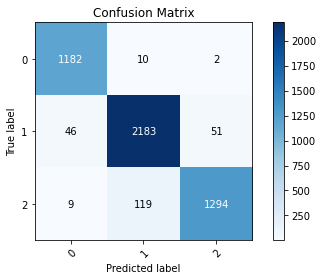

In [ ]:
plot_confusion_matrix(np.array(y_true),np.array(y_pred), classes = ['0','1','2'], title='Confusion Matrix')

In [ ]:
CM_sub = {"y_true" : y_true, "y_pred" : y_pred}

In [ ]:
# Evaluating based on structure. (x_structs, y_structs, struct_names)
struct_true = []
struct_pred = []

In [ ]:
#generate label for structures from one-hot encoding
temp = (np.argmax(y_structs, axis=1))
for i in range(len(temp)):
  struct_true.append(int(temp[i]))

In [ ]:
#generate prediction for structures
for i in range(len(y_structs)):
  frame_y = []
  # run a sliding window through temporal dimension of entire video to feed frames into model by batch
  for j in range(0, len(x_structs[i])-vid_len, step):
    struct_new_pred = model.predict(np.expand_dims(x_structs[i][j:j+vid_len], axis=0), batch_size=1, verbose=0)
    struct_new = np.argmax(struct_new_pred,axis=1)
    frame_y.append(int(struct_new[0]))
    
  #account for last window element of the list
  struct_new_pred = model.predict(np.expand_dims(x_structs[i][-vid_len:], axis=0), batch_size=1, verbose=0)
  struct_new = np.argmax(struct_new_pred,axis=1)
  #collect labels for each sliding window
  frame_y.append(int(struct_new[0]))
    
  #aggregate scores for each structure
  if (2 in frame_y):
    struct_pred.append(2)
  elif (1 in frame_y):
    struct_pred.append(1)
  else:
    struct_pred.append(0)

Predicted Structures: [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
True Structures: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1,

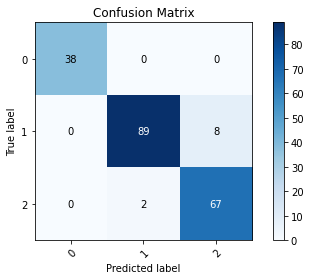

In [ ]:
  struct_scores = accuracy_score(struct_true, struct_pred)
  print('Predicted Structures:',struct_pred)
  print('True Structures:', struct_true)
  plot_confusion_matrix(np.array(struct_true),np.array(struct_pred), classes = ['0','1','2'], title='Confusion Matrix')
  CM = {"y_true" : struct_true,
        "y_pred" : struct_pred}